<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Muscle activations & muscles forces

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
suffix = "_StaticOptimization_activation"

act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/3_static_optimization/*{suffix}*")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC3,GH1,GH2,GH3,filename,participant,men,height,mass,n_trial
0,0.00,0.010001,0.010003,0.010001,0.010000,0.010000,0.010000,0.010000,0.010001,0.918577,...,0.197347,-0.009783,0.018975,-0.013833,CamBF6H2_2,camb,0,2,6,2
1,0.01,0.010008,0.010023,0.010005,0.010002,0.010000,0.010002,0.010003,0.010004,0.981332,...,0.012865,-0.014570,0.022495,-0.004664,CamBF6H2_2,camb,0,2,6,2
2,0.02,0.054300,0.426400,0.012475,0.010014,0.010001,0.010070,0.010018,0.010021,0.433334,...,0.017376,-0.020438,0.025611,0.008201,CamBF6H2_2,camb,0,2,6,2
3,0.03,0.121485,0.400511,0.294346,0.110924,0.010019,0.017028,0.010012,0.010007,0.234726,...,0.175679,-0.038571,0.050428,0.017728,CamBF6H2_2,camb,0,2,6,2
4,0.04,0.050626,0.282258,0.168071,0.045368,0.010018,0.010079,0.010012,0.010009,0.179329,...,0.079193,-0.031775,0.041177,0.015128,CamBF6H2_2,camb,0,2,6,2


In [5]:
offset = 0.05  # take .5 second before and after onsets
emg = []

for filename in conf.project_path.glob("*/_conf.json"):
    participant = filename.parent.stem

    onsets = conf.get_conf_field(participant, ["onset"])
    onsets = {
        key: [values[0] - offset, values[1] + offset] for key, values in onsets.items()
    }

    for key, value in onsets.items():
        emg_filename = filename.parent / "0_emg" / f"{key}.sto"

        if emg_filename.is_file:
            e = Analogs3d.from_sto(emg_filename)

            idx = np.logical_and(
                e.get_time_frames < value[1], e.get_time_frames > value[0]
            )

            emg.append(
                e[..., idx]
                .time_normalization()
                .to_dataframe()
                .assign(filename=emg_filename.stem)
            )

emg = (
    pd.concat(emg)
    .pipe(parse_conditions, suffix="", prefix="")
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)
emg.head()

,index,deltant,deltmed,deltpost,biceps,triceps,uptrap,lotrap,serratus,ssp,isp,subs,pect,latissimus,filename,participant,men,height,mass,n_trial
404,0.00,0.114197,0.058601,0.014573,0.053190,0.022817,0.047951,0.151383,0.086940,0.050282,0.095726,0.050806,NaN,NaN,CamBF12H2_1,camb,0,2,12,1
405,0.01,0.133316,0.068284,0.017511,0.105164,0.026484,0.067053,0.183498,0.119571,0.063062,0.115351,0.055467,NaN,NaN,CamBF12H2_1,camb,0,2,12,1
406,0.02,0.139726,0.090586,0.019676,0.150051,0.033946,0.076714,0.238565,0.146495,0.076493,0.147490,0.063542,NaN,NaN,CamBF12H2_1,camb,0,2,12,1
407,0.03,0.134340,0.123589,0.020416,0.163273,0.041905,0.088991,0.284277,0.161037,0.090171,0.179503,0.070484,NaN,NaN,CamBF12H2_1,camb,0,2,12,1
408,0.04,0.130558,0.164350,0.021960,0.155447,0.046424,0.126223,0.301388,0.169885,0.109233,0.196272,0.071917,NaN,NaN,CamBF12H2_1,camb,0,2,12,1


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [6]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(act)

Initial
n. participants: 37
----------
men
0    110
1    101
----------
height
2    211
----------
mass
6     106
12    105
----------
men  mass
0    6       54
     12      56
1    6       52
     12      49
----------


In [7]:
balanced_trials = random_balanced_design(
    act, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
act = act.query("filename == @balanced_trials")
emg = emg.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(act)

Balanced:
n. participants: 37
----------
men
0    98
1    98
----------
height
2    196
----------
mass
6     98
12    98
----------
men  mass
0    6       49
     12      49
1    6       49
     12      49
----------


### Drop unwanted variables

In [8]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,CamBF6H2_2,camb,0,2,6,2,0.00,LVS,0.010001
1,CamBF6H2_2,camb,0,2,6,2,0.01,LVS,0.010008
2,CamBF6H2_2,camb,0,2,6,2,0.02,LVS,0.054300
3,CamBF6H2_2,camb,0,2,6,2,0.03,LVS,0.121485
4,CamBF6H2_2,camb,0,2,6,2,0.04,LVS,0.050626


In [9]:
emg_melt = emg.melt(id_vars=id_vars)
emg_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,CamBF12H2_1,camb,0,2,12,1,0.00,deltant,0.114197
1,CamBF12H2_1,camb,0,2,12,1,0.01,deltant,0.133316
2,CamBF12H2_1,camb,0,2,12,1,0.02,deltant,0.139726
3,CamBF12H2_1,camb,0,2,12,1,0.03,deltant,0.134340
4,CamBF12H2_1,camb,0,2,12,1,0.04,deltant,0.130558


In [10]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
    "hand_r_s2h_Fx",
    "hand_r_s2h_Fy",
    "hand_r_s2h_Fz",
    "hand_r_s2h_Tx",
    "hand_r_s2h_Ty",
    "hand_r_s2h_Tz",
]

act_melt = act_melt.query("variable != @blacklist")

## $\sum$activation

In [23]:
sum_act = (
    act_melt.groupby(id_vars)["value"]
    .sum()
    .reset_index()
    .eval("value = (value - value.mean())/value.std()")
)
sum_act.head()

,filename,participant,men,height,mass,n_trial,index,value
0,AimQF12H2_1,aimq,0,2,12,1,0.00,-0.976671
1,AimQF12H2_1,aimq,0,2,12,1,0.01,-1.066338
2,AimQF12H2_1,aimq,0,2,12,1,0.02,-1.104176
3,AimQF12H2_1,aimq,0,2,12,1,0.03,-1.077036
4,AimQF12H2_1,aimq,0,2,12,1,0.04,-0.963489


In [24]:
sum_emg = (
    emg_melt.groupby(id_vars)["value"]
    .sum()
    .reset_index()
    .eval("value = (value - value.mean())/value.std()")
)
sum_emg.head()

,filename,participant,men,height,mass,n_trial,index,value
0,AimQF12H2_1,aimq,0,2,12,1,0.00,0.291527
1,AimQF12H2_1,aimq,0,2,12,1,0.01,0.247866
2,AimQF12H2_1,aimq,0,2,12,1,0.02,0.145308
3,AimQF12H2_1,aimq,0,2,12,1,0.03,0.152739
4,AimQF12H2_1,aimq,0,2,12,1,0.04,0.252777


In [25]:
df_comp = pd.concat(
    [sum_act.assign(variable="activation"), sum_emg.assign(variable="emg")]
).drop(["filename", "participant", "height", "n_trial"], axis=1)

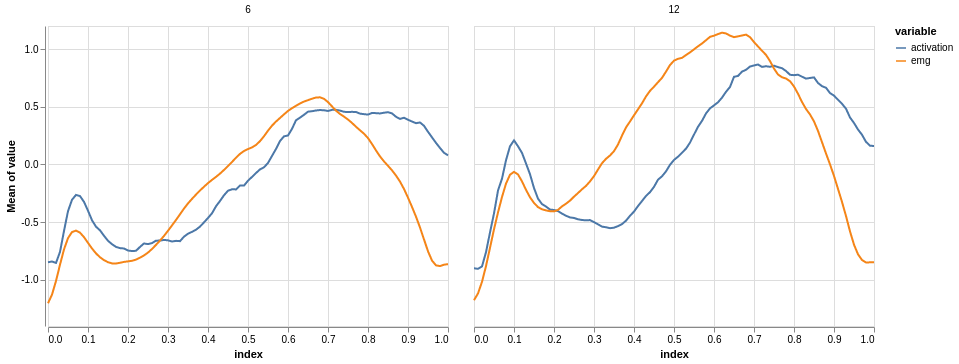

In [31]:
alt.Chart().mark_line().encode(
    alt.X("index"), alt.Y("mean(value)"), alt.Color("variable")
).facet(data=df_comp, column=alt.Column("mass", title=None))

In [35]:
base = alt.Chart(df_comp).encode(
    alt.X(
        "index", title="Normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Z-score"))
sigma = base.mark_errorband(extent="ci").encode(alt.Y("value", title=None))

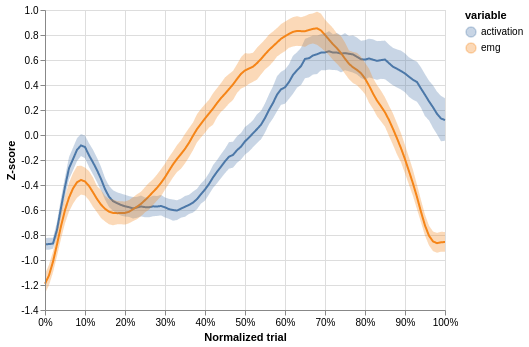

In [38]:
(mu + sigma).encode(alt.Color("variable"))

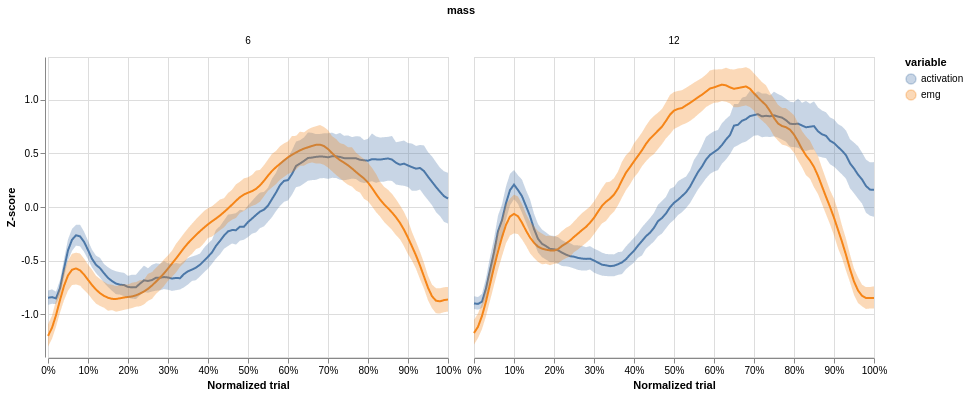

In [37]:
(mu + sigma).encode(alt.Color("variable")).facet(column="mass")

<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >